# Introduction to the PyFD package

## Setup
In this first tutorial, we will demonstrate how to apply the package in an end-to-end fashion on a toy dataset.
Future tutorials will focus on real-world use-cases and datasets. We shall investigate a toy example with an input $x$ containing five features sampled from a Gaussian distribution $\mathcal{N}(0, \Sigma)$ with an identity covariance matrix, except for correlations $\Sigma_{1, 2} = \Sigma_{2, 1} = \rho_{1,2}$ and 
$\Sigma_{4, 5} = \Sigma_{4, 5} = \rho_{4,5}$. The predictive model to explain has the following form

$$ h(x) = \alpha x_1 x_2 \,1[x_3\geq 0] + \beta x_4 x_5 \,1[x_3< 0].$$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def generate_problem(N, seed, rho_12, rho_45, alpha, beta):
    # Generate input
    np.random.seed(seed)
    cov = np.eye(5)
    cov[0, 1] = rho_12
    cov[1, 0] = rho_12
    cov[3, 4] = rho_45
    cov[4, 3] = rho_45
    X = np.random.multivariate_normal(np.zeros(5), cov=cov, size=(N,))

    # Model to explain
    def h(X):
        return alpha * X[:, 0] * X[:, 1] * (X[:, 2]>=0).astype(np.int64) +\
                beta * X[:, 3] * X[:, 4] * (X[:, 2]<0).astype(np.int64)

    return X, h

# We generate the data and models. The data X is stored in a (N, d) numpy array
X, h = generate_problem(1000, 42, 0.5, 0.75, 1, 2)

The first step of the PyFD framework is to define a `Features` object that represents the various
features encoded in the **X** matrix. Here are the various feature types supported in PyFD.

<p align="center">
    <img src="./Images/Features.png" width="600">
</p>

In [2]:
from pyfd.features import Features

# In this simple example, all features are numerical
features = Features(X, names=[f"x{i}" for i in range(1, 6)], types=["num"]*5)
# The summary() method provides an overview of the features
features.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | x1                 | num                | inf        | [0]              |
| 1 | x2                 | num                | inf        | [1]              |
| 2 | x3                 | num                | inf        | [2]              |
| 3 | x4                 | num                | inf        | [3]              |
| 4 | x5                 | num                | inf        | [4]              |
-------------------------------------------------------------------------------



## Computing Additive Explanations
### Functional Decompositions

After setting the problem (the data **X**, the model $h$, and the `features`), we can leverage PyFD to compute functional decompositions, that is, decomposing $h$ as

$$ h(x) = \text{intercept} + \sum_i h_i(x_i) + \sum_{i<j}h_{ij}(x_i, x_j) + \ldots,$$

where the function $h_i$ only depends on $x_i$, $h_{ij}$ only depends on $x_i$ and $x_j$, etc. Future 
tutorials will discuss how these decompositions in more details.
For now, it is sufficient to understand that PyFD stores the $h_u$ terms in a `dict` with `tuple` keys.

In [3]:
from pyfd.decompositions import get_components_adaptive

# Compute the functional decomposition h = intercept + sum_i h_i + ...
decomposition = get_components_adaptive(h, X, features, tolerance=1e-2)

# The keys are tuples encoding subsets of features
print(decomposition.keys())
# The () key is the intercept
print(decomposition[()].shape)
# The key (0,) is the term h_1(x_1)
print(decomposition[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (3, 4), (2, 3), (2, 4), (2, 3, 4), (0, 2), (0, 1), (1, 2), (0, 1, 2)])
(1000,)
(1000, 1000)


The functional decomposition can de visualized as a directed graph, whose nodes are groups of features $ijk$ involved in a term $h_{ijk}(x_i,x_j,x_k)$.

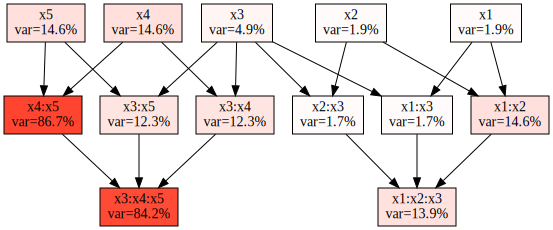

In [4]:
from pyfd.plots import decomposition_graph

dot = decomposition_graph(decomposition, features.names())
dot.render(filename=os.path.join("Images", "1-1-lattice"), format='pdf')
dot

According to this plot, the model exhibits high-order dependence between the triplets $x_1:x_2:x_3$ and $x_3:x_4:x_5$.<br>
Here is how to plot the $h_1, h_2, \ldots, h_5$ terms.

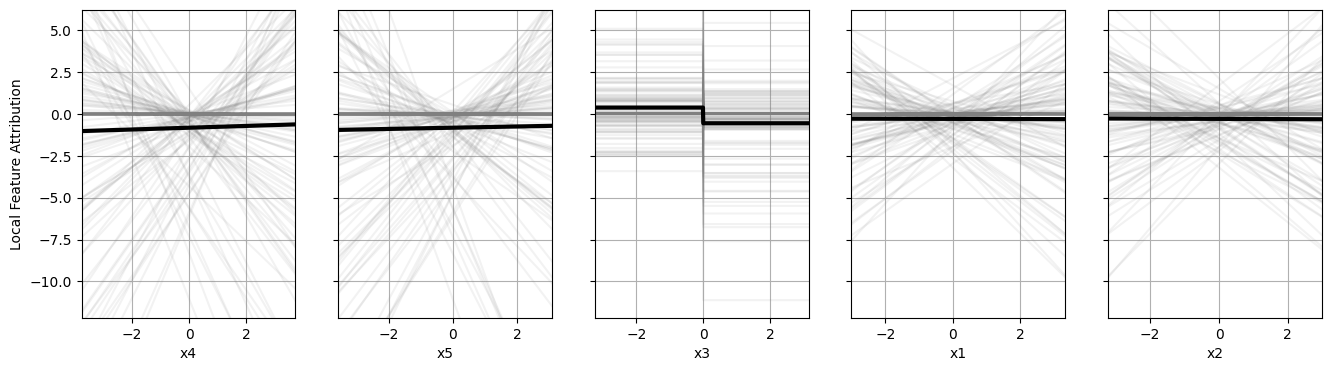

In [5]:
from pyfd.plots import partial_dependence_plot

# The following function can plot the h_1, h_2, h_3, h_4, and h_5 terms.
partial_dependence_plot(decomposition, X, features, n_cols=5, figsize=(16, 4))
plt.savefig(os.path.join("Images", "1-1-main_effects"), bbox_inches="tight")

Future tutorials will explain how to interpret these curves. In short, they represent the effect of varying feature $x_i$ on the model output. If the curve's slope is positive, then increasing $x_i$ increases the model output. Additionally, negative slopes imply that increasing $x_i$ decreases the model output. Since the curves presented here are not all parallel (some they have negative and positive slopes), we suspect the model $h$ is 
too complicated to be interpreted this way.

### Shapley Values

An alternative to computing the full functional decomposition is to compute Shapley values that attribute an importance to each of the $5$ features.

$$ h(x) - \mathbb{E}[h(X)] = \sum_{i=1}^5 \phi^{\text{SHAP}}_i(h, x).$$

In [6]:
from pyfd.shapley import lattice_shap
from pyfd.plots import attrib_scatter_plot

# Shapley Values can be computed using the list of h_u terms `decomposition.keys()`.
shap_values = lattice_shap(h, X, X, features=features, interactions=list(decomposition.keys()) )
# The shapley values are stored in a `(N, 5)` numpy array so we have 5 feature importance scores per instances.
print(shap_values.shape)

Shapley Values: 14it [00:00, 27.41it/s]

(1000, 5)


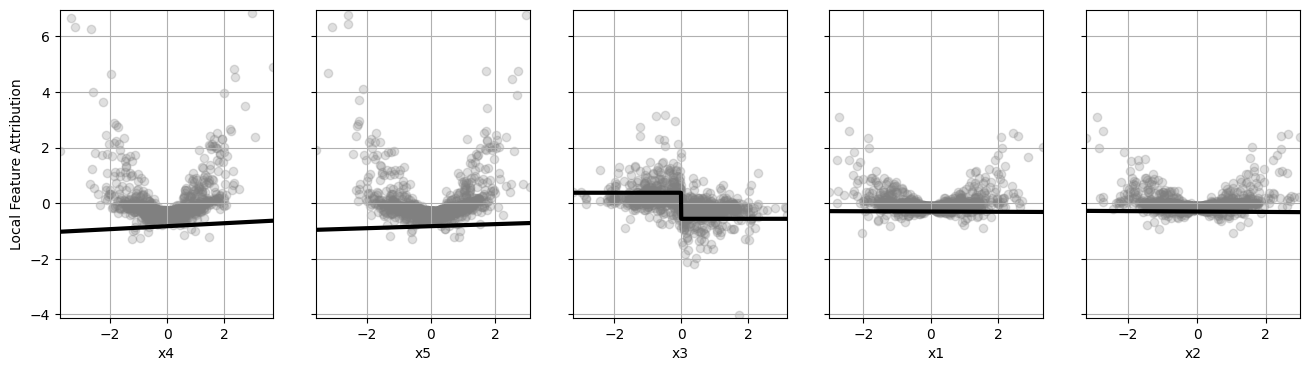

In [7]:
# The following function plots the Shapley Values alongside the h_i terms
attrib_scatter_plot(decomposition, shap_values, foreground=X, features=features, n_cols=5, figsize=(16, 4))
plt.savefig(os.path.join("Images", "1-1-SHAP.png"), bbox_inches="tight")

In this plot, the dark lines are the $h_i$ terms while the grey dots are the Shapley values $\phi^{\text{SHAP}}_i$. Note that the Shapley values disagree greatly with the $h_i$ terms of the decomposition. Moreover, Shapley values are spread-out vertically, which we interpret as a form of noise that prohibits us from gaining general insight 
on the impacts features have on the model response.

A final type of explanations we can extract from model $h$ are **global feature importance**, that convey how 
much **variability** the feature $x_i$ induces on the model. PyFD offers functions to compute global importance from functional decompositions and Shapley values.

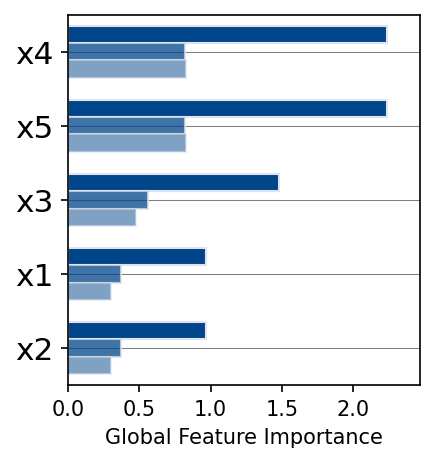

In [8]:
from pyfd.decompositions import get_PDP_PFI_importance
from pyfd.shapley import get_SHAP_importance
from pyfd.plots import bar, decomposition_graph

# We compute PDP and PFI global feature importance using the functional decomposition
I_PDP, I_PFI = get_PDP_PFI_importance(decomposition)
# We compute SHAP global feature importance using the Shapley Values
I_SHAP = get_SHAP_importance(shap_values)
plt.figure(figsize=(3, 3), dpi=150)
bar([I_PFI, I_SHAP, I_PDP], features.names(), ax=plt.gca())
plt.xlabel("Global Feature Importance")
plt.savefig(os.path.join("Images", "1-1-GFI"), bbox_inches="tight")

This bar chart presents the global feature importance using three techniques. The Permutation Feature Importance (PFI) is shown in blue. The Shapley Importance is semi-transparent blue while the Partial Dependence Plot (PDP) 
is transparent blue. Observe that the three techniques disagree strongly regarding the importance of the 
various features.

## Increasing Explanations Alignment

At this point, you might feel frustrated that we presented as series of explainability methods (functional decompositions, Shapley values, global feature importance)but we did not get clear insights on $h$ based on them. The reason being that the many techniques **disagree** so it is hard to know which one provides the correct
model interpretation. Our solution? *Increase the alignment/agreement among the techniques to get an un-ambiguous interpretation of $h$*.

To increase alignment among the methods, we must minimize so-called **feature interaction**, which will 
be introduced in future tutorials. For the moment, we simply employ the `get_CoE` function that reports the strength of feature interactions in the functional decomposition.

In [9]:
from pyfd.decompositions import get_CoE

print(get_CoE(decomposition))

211.4352510400135


This score is very high, implying that strong feature interactions prohibit agreement among the explainability techniques. PyFD offers two methodologies to reduce feature interactions : feature grouping and FD-Trees.

### Feature Grouping

In PyFD, we can interpret the separate effects of features $x_1, x_2, \ldots, x_5$, but we can also report the **joint** effect of **groups** of features. This is important in scenarios where input features are involved in correlations.

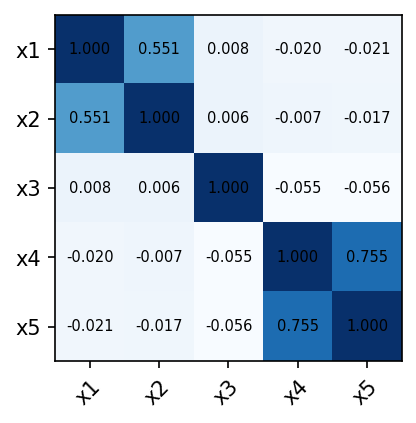

In [10]:
# Compute feature correlations
correlations = np.corrcoef(X.T)

# Plot as a heatmap
plt.figure(figsize=(3, 3), dpi=150)
im = plt.imshow(correlations, cmap='Blues')
# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(5), labels=features.names())
plt.yticks(np.arange(5), features.names())

# Rotate the tick labels and set their alignment.
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(5):
        plt.text(j, i, f"{correlations[i, j]:.3f}", ha="center", va="center", color="k", size=7)

Text(0, 0.5, 'x5')

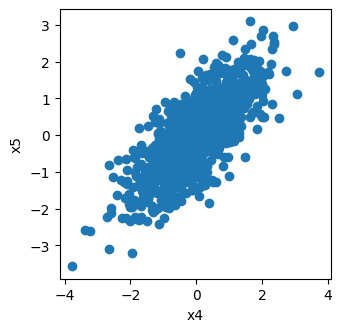

In [11]:
# Plot x4 and x5
plt.figure(figsize=(3.5, 3.5))
plt.scatter(X[:, 3], X[:, 4])
plt.xlabel("x4")
plt.ylabel("x5")

As a general rool-of-thumb, PyFD advocates treating correlated features as a single **group**. This is because is it hard to disentangle the effect of two correlated variables. Imagine for instance that $x_4$ measures a 
house surface area while $x_5$ counts its  number of rooms. Both of these features are correlated and encode different notions of **house size**. By grouping them, we would give a single importance to the notion of **size** rather than the specific measures encoded in each feature. 

While feature correlations are not equivalent to feature interactions, we observed empirically that grouping correlated features also tends to decrease feature interactions. Hence, grouping features should reduce the `get_CoE` interaction strength.

In [12]:
# Grouping features with the group method
grouped_features = features.group([[0, 1], [3, 4]])
grouped_features.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | x3                 | num                | inf        | [2]              |
| 1 | x1:x2              | num:num            | inf:inf    | [0, 1]           |
| 2 | x4:x5              | num:num            | inf:inf    | [3, 4]           |
-------------------------------------------------------------------------------



The `summary()` method indicates that features $x_1:x_2$ are now treated as a group and $x_4:x_5$ are treated as another. This `grouped_features` object can then be passed to PyFD in order to compute the corresponding functional decomposition.

In [13]:
# Passing the grouped_features object to the functional decomposition algorithm
grouped_decomposition = get_components_adaptive(h, X, features=grouped_features)
print(grouped_decomposition.keys())
print(grouped_decomposition[()].shape)
print(grouped_decomposition[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (0, 2), (0, 1)])
(1000,)
(1000, 1000)


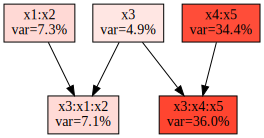

In [14]:
# Visualizing the decomposition
dot = decomposition_graph(grouped_decomposition, grouped_features.names())
dot.render(filename=os.path.join("Images", "1-1-lattice_grouped"), format='pdf')
dot

In this new functional decompostion, we do not have terms $h_4$ and $h_5$ for the separate features $x_4$ and $x_5$. This is because these features are now part of a group. We can also compute Shapley values on the grouped features, which will lead to **three** Shapley values per datum.

In [15]:
grouped_shap_values = lattice_shap(h, X, X, features=grouped_features,
                                    interactions=list(grouped_decomposition.keys()))
print(grouped_shap_values.shape)

Shapley Values: 6it [00:00, 28.76it/s]

(1000, 3)


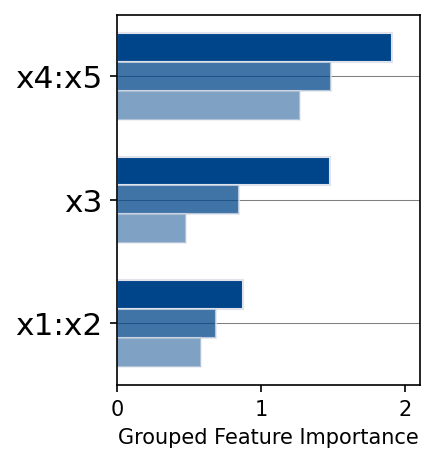

In [16]:
# Computing the global feature importance with grouped features
I_PDP_g, I_PFI_g = get_PDP_PFI_importance(grouped_decomposition)
I_SHAP_g = get_SHAP_importance(grouped_shap_values)
plt.figure(figsize=(3, 3), dpi=150)
bar([I_PFI_g, I_SHAP_g, I_PDP_g], grouped_features.names(), ax=plt.gca())
plt.xlabel("Grouped Feature Importance")
plt.savefig(os.path.join("Images", "1-1-GFI_grouped.png"), bbox_inches="tight")

In [17]:
print(get_CoE(grouped_decomposition))

42.77350666733114


The CoE interaction score has reduced considerably by grouping features together. But there is clearly room for more improvement.

### FD-Trees

In addition to grouping features, PyFD allows to reduce feature interactions by explaining the model $h$ on well-chosen **regions**. These regions are obtained by a so-called Functional Decomposition Tree (FD-Tree for short) trained to minimize feature interactions within its leaves.

In [18]:
from pyfd.fd_trees import CoE_Tree

# The FD-Tree constructor needs the ungrouped features
tree = CoE_Tree(features, max_depth=1)
# We fit the FD-Tree on the grouped decomposition
tree.fit(X, grouped_decomposition)
tree.print(verbose=True)

LoA 0.4277
Samples 1000
If x3 ≤ 0.0224:
|   LoA 0.0153
|   Samples 500
|   Region 0
else:
|   LoA 0.0000
|   Samples 500
|   Region 1
Final LoA 0.0153


The FD-Tree has decided that the optimal way to partition the input space into regions is to consider the sign of feature $x_3$. Doing so has decreased the CoE (here called LoA) from 42.7% to 1.53%. This is a considerable reduction in feature interactions. As a result, we expect explainability technques to have a high agreement/alignment if they are restricted to the leaves of this FD-Tree.

In [19]:
# The predict method maps each datum to its region (0 or 1)
regions = tree.predict(X)
print(regions[:10])
# The rules method return a dict that described each region
rules = tree.rules()
print(rules)

[1 1 1 1 1 1 0 0 0 1]
{0: 'x3<=0.02', 1: 'x3>0.02'}


In [20]:
# Using regional distributions 
regional_X = [[], []]
regional_decomposition = [[], []]
regional_shap = [[], []]
for r in range(2):
    print(f"Region {r}")
    regional_X[r] = X[regions==r]
    # Regional Decomposition
    regional_decomposition[r] = get_components_adaptive(h, regional_X[r], features=grouped_features, tolerance=1e-2)
    # Regional Shapley values
    regional_shap[r] = lattice_shap(h, regional_X[r], regional_X[r], features=grouped_features, 
                                            interactions=list(regional_decomposition[r].keys()))

Region 0


Shapley Values: 5it [00:00, 80.85it/s]


Region 1


Shapley Values: 4it [00:00, 79.01it/s]


Once regional functional decompositions and Shapley values have been computed, one can report global feature importance on the separate regions as follows.

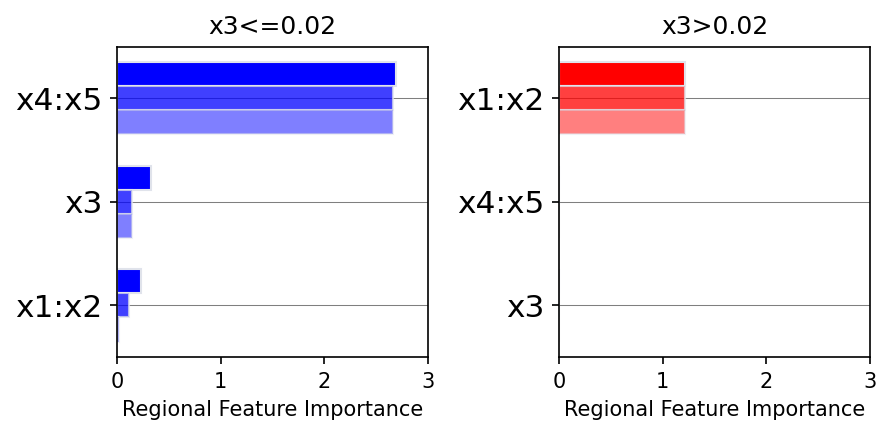

In [21]:
from pyfd.plots import COLORS
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150)
for r in range(2):
    I_PDP, I_PFI = get_PDP_PFI_importance(regional_decomposition[r])
    I_SHAP = get_SHAP_importance(regional_shap[r])
    bar([I_PFI, I_SHAP, I_PDP], grouped_features.names(), ax=axes[r], color=COLORS[r])
    axes[r].set_xlim(0, 3)
    axes[r].set_xlabel("Regional Feature Importance")
    axes[r].set_title(rules[r])
plt.savefig(os.path.join("Images", "1-1-GFI_grouped_regional"), bbox_inches="tight")

As predicted by the low CoE, the PDP/SHAP/PFI global importance techniques have an almost perfect agreement when they are used in the two separate regions. Since the various techniques agree, we argue they provide more 
faithfull descriptions of the model behavior.

This is the main motivation behind the PyFD library. Instead of simply providing a suite of high-level APIs 
for computing model explanations, we let **disagreements** between PDP/SHAP/PFI techniques be an incentive for 
the user to increase agreements by either grouping features or finding regions with an FD-Tree. As such, the library is fundamentally meant to be **interactive** : users play with feature grouping and FD-Trees and decides what is the optimal way to frame explainability within their use-cases. The subsequent two tutorials 
will illustrate how this framework is applicable to real-world regression and classification problems.